In [19]:
query = 'RAG'

In [20]:
import os, sys, nltk
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from Preprocess import load_df, load_pickle, load_pickle_files,prep_query
from Searching_Method.Neural_Reranking import retrieve_and_rerank
from Searching_Method.BM25andDenseEmbeddings import load_split_embeddings, combined_ranking
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import matplotlib.pyplot as plt
from rank_bm25 import BM25Okapi
from IPython.display import display, HTML

# preprocess
if os.path.exists('./bm25-vector-search/data/'):
    path = './bm25-vector-search/data/'
elif os.path.exists('./data/'):
    path = './data/'
else:
    print('Error: Could not find data directory')
    print('Please run from either root or bm25-vector-search directory')
    exit(1)

print('Loading DataFrame...')
df = load_df(path + 'arxiv_csAI_subset.json.gz')

print('Loading Pickle Files...')
titles_file = path + 'titles_inverted_indices.pkl.gz'
abstracts_file = path + 'abstracts_inverted_indices.pkl.gz'
title_term_table = load_pickle(titles_file)
abstract_term_table = load_pickle(abstracts_file)

titles_file = path + 'titles_lengths.pkl.gz'
abstracts_file = path + 'abstracts_lengths.pkl.gz'
title_lengths = load_pickle(titles_file)
abstract_lengths = load_pickle(abstracts_file)

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

stemmer = SnowballStemmer('english')
# BM25 Configuration Variables
N = len(title_lengths)
avg_doc_len_title = sum(title_lengths.values()) / N
avg_doc_len_abs = sum(abstract_lengths.values()) / N
# Load the split embedding files
document_embeddings = load_split_embeddings(path)
model = SentenceTransformer('all-MiniLM-L6-v2')
query = prep_query(query, stop_words, stemmer)

Loading DataFrame...
Loading Pickle Files...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\b0750\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Level 1_TF-IDF

In [7]:
import pandas as pd
import re
"""#Global TF-IDF feature for the whole dataset"""

def plot_top_tfidf_features(vectorizer, matrix, top_n=20):
    """
    Plots the top N terms by their average TF-IDF score across all documents.
    This helps visualize which terms are most significant in the dataset.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Calculate average TF-IDF score for each term
    # mean(axis=0) returns a matrix, so we flatten it to a 1D array
    avg_scores = np.array(matrix.mean(axis=0)).flatten()

    # Get feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Create a DataFrame
    features_df = pd.DataFrame({
        'term': feature_names,
        'score': avg_scores
    })

    # Sort and take top N
    top_features = features_df.sort_values(by='score', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(top_features['term'], top_features['score'], color='#2c3e50')
    plt.xlabel('Average TF-IDF Score')
    plt.ylabel('Term')
    plt.title(f'Top {top_n} Most Important Terms by TF-IDF Score')
    plt.gca().invert_yaxis()  # Highest score at the top
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
def plot_relevance_bars(results, query):
    plt.figure(figsize=(10, 5))
    titles = [t[:50] + '...' if len(t) > 50 else t for t in results['title']]
    scores = results['relevance_score'].values

    plt.barh(range(len(titles)), scores, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(titles))))
    plt.yticks(range(len(titles)), titles)
    plt.xlabel('Relevance Score')
    plt.title(f'Top Results for: "{query}"')
    plt.gca().invert_yaxis() # Best result at top
    plt.tight_layout()
    plt.show()

def plot_wordcloud(results):
    text = ' '.join(results['combined_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Common Terms in Search Results')
    plt.tight_layout()
    plt.show()


In [4]:

df['cleaned_text'] = df['title'] + " " + df['abstract']

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print(f"TF-IDF Matrix Built: {tfidf_matrix.shape}")

TF-IDF Matrix Built: (150867, 5000)


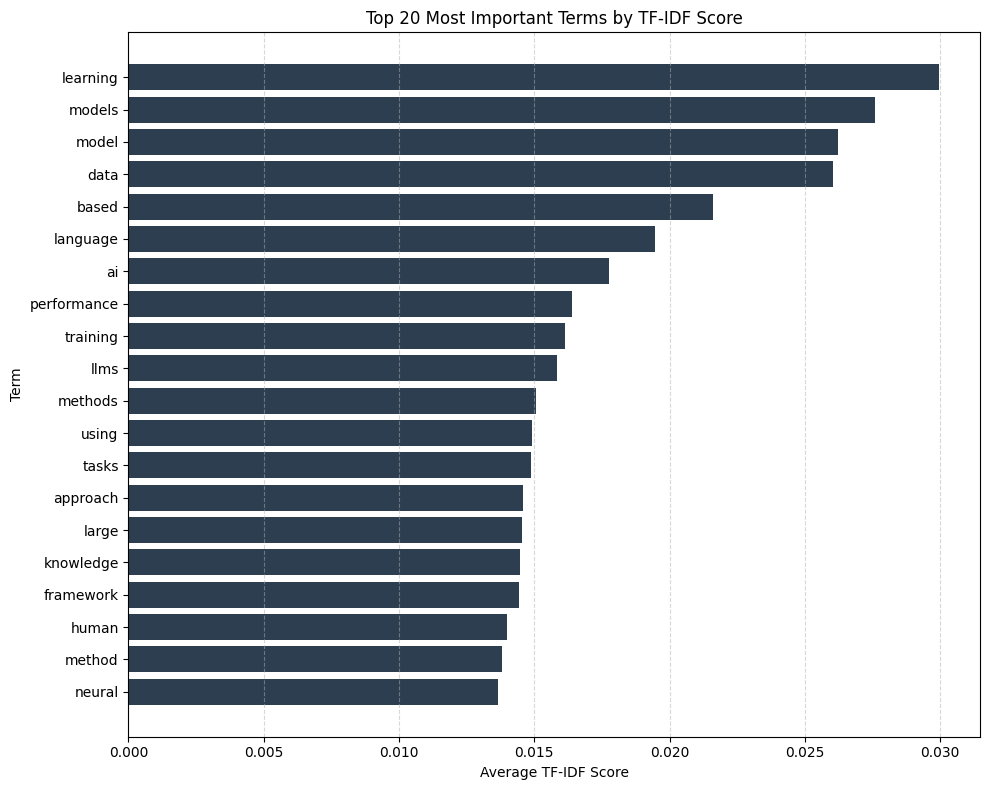

In [5]:
# Call the function (assuming tfidf_vectorizer and tfidf_matrix exist from Part 2)
plot_top_tfidf_features(tfidf_vectorizer, tfidf_matrix)

In [8]:
from Searching_Method.TFIDF import TFIDF
import matplotlib.pyplot as plt

TFIDF = TFIDF(df)  
results, _ = TFIDF.search_papers(query, top_n=20)
plot_relevance_bars(results, query)

NameError: name 'plot_relevance_bars' is not defined

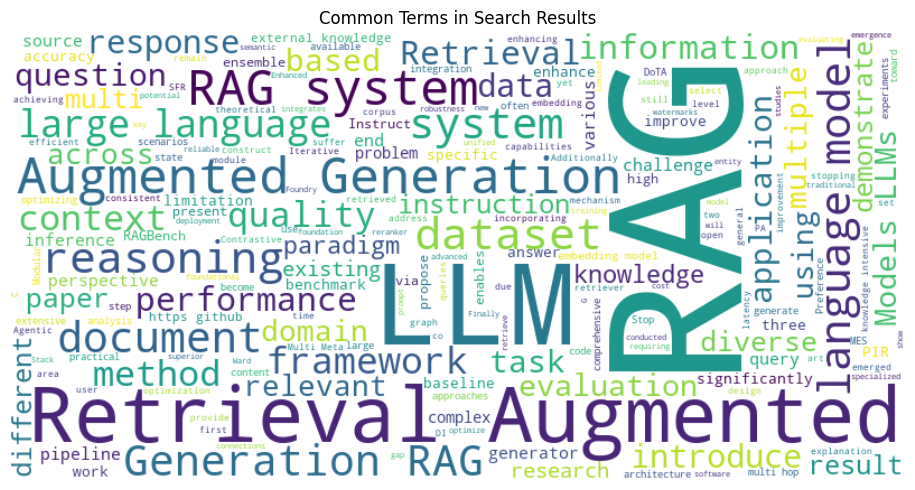

In [14]:
from wordcloud import WordCloud
plot_wordcloud(results)

In [26]:
# from pyvis.network import Network
# import json
# import networkx as nx
# def parse_authors(auth_str):
#     if not isinstance(auth_str, str): return []
#     return [a.strip() for a in auth_str.replace(' and ', ', ').split(',') if a.strip()]

# df['author_list'] = df['authors'].apply(parse_authors)

# def plot_community_network(G, communities_detected, community_names_map, filename='community_bridge_network.html'):
#         node_community_map = {}
#         for i, comm in enumerate(communities_detected):
#             for node in comm:
#                 node_community_map[node] = i

#         bridge_nodes = []
#         for node in G.nodes():
#             my_comm = node_community_map.get(node)
#             neighbors = list(G.neighbors(node))
#             if not neighbors: continue
#             foreign_neighbors = sum(1 for v in neighbors if node_community_map.get(v) != my_comm)
#             if foreign_neighbors > 0:
#                 bridge_nodes.append(node)

#         net = Network(notebook=True, height="650px", width="100%", bgcolor="#111111", font_color="white", cdn_resources='in_line')

#         author_to_categories_map = {}
#         for idx, row in df.iterrows():
#             authors = row['author_list']
#             paper_categories = row['categories'].split()
#             for author in authors:
#                 if author not in author_to_categories_map:
#                     author_to_categories_map[author] = set()
#                 author_to_categories_map[author].update(paper_categories)

#         for node in G.nodes():
#             comm_id = node_community_map.get(node)
#             is_bridge = node in bridge_nodes
#             node_shape = 'diamond' if is_bridge else 'dot'
#             node_size = 25 if is_bridge else 15
#             node_border_width = 3 if is_bridge else 1
#             node_color_config = {'border': '#FF0000', 'highlight': {'border': '#FFD700'}} if is_bridge else None
#             author_cats = sorted(list(author_to_categories_map.get(node, set())))
#             categories_str = ", ".join(author_cats) if author_cats else "N/A"
#             descriptive_community_name = community_names_map.get(comm_id, 'Undefined Community')
#             title_text = f"Author: {node}\nCommunity: {descriptive_community_name}\nCategories: {categories_str}"
#             if is_bridge:
#                 title_text += "\n(Cross-domain Bridge!)"
#             net.add_node(
#                 node, label=node, group=comm_id, title=title_text,
#                 font={'size': 14, 'color': 'white'}, shape=node_shape, size=node_size,
#                 borderWidth=node_border_width, color=node_color_config
#             )

#         for source, target, data in G.edges(data=True):
#             net.add_edge(source, target, value=data['weight'], color='#444444')

#         physics_options = {
#             "physics": {
#                 "solver": "forceAtlas2Based",
#                 "forceAtlas2Based": {"gravitationalConstant": -40000, "centralGravity": 0.2, "springLength": 120, "springConstant": 0.05, "avoidOverlap": 0.5},
#                 "stabilization": {"iterations": 3000, "fit": True, "enabled": True}
#             }
#         }
#         net.set_options(json.dumps(physics_options))
#         net.save_graph(filename)
#         with open(filename, "r", encoding="utf-8", errors="ignore") as f:
#             html = f.read()
#         with open(filename, "w", encoding="utf-8") as f:
#             f.write(html)
#         with open(filename, 'r', encoding='utf-8') as f:
#             display(HTML(f.read()))

In [27]:
# author_subgraph = TFIDF.build_author_network(min_edge_weight=2, top_nodes_count=80)
# communities = TFIDF.detect_communities(author_subgraph)
# community_names = TFIDF.generate_community_names(communities)
# plot_community_network(author_subgraph, communities, community_names)

UnicodeEncodeError: 'charmap' codec can't encode characters in position 263607-263621: character maps to <undefined>

In [25]:
# def plot_community_bridges_network(G, communities_detected, community_names_map, author_to_categories_map, filename='community_bridge_network.html'):
#     """
#     Plots an interactive network with community detection and bridge author highlighting.
#     """
#     node_community_map = {}
#     for i, comm in enumerate(communities_detected):
#         for node in comm:
#             node_community_map[node] = i

#     bridge_nodes = []
#     for node in G.nodes():
#         my_comm = node_community_map.get(node)
#         neighbors = list(G.neighbors(node))
#         if not neighbors:
#             continue
#         foreign_neighbors = sum(1 for v in neighbors if node_community_map.get(v) != my_comm)
#         if foreign_neighbors > 0:
#             bridge_nodes.append(node)

#     net = Network(notebook=True, height="650px", width="100%", bgcolor="#111111", font_color="white", cdn_resources='in_line')

#     for node in G.nodes():
#         comm_id = node_community_map.get(node)
#         is_bridge = node in bridge_nodes

#         node_shape = 'diamond' if is_bridge else 'dot'
#         node_size = 25 if is_bridge else 15
#         node_border_width = 3 if is_bridge else 1
#         node_color_config = {'border': '#FF0000', 'highlight': {'border': '#FFD700'}} if is_bridge else None

#         author_cats = sorted(list(author_to_categories_map.get(node, set())))
#         categories_str = ", ".join(author_cats) if author_cats else "N/A"
#         descriptive_community_name = community_names_map.get(comm_id, 'Undefined Community')

#         title_text = f"Author: {node}\nCommunity: {descriptive_community_name}\nCategories: {categories_str}"
#         if is_bridge:
#             title_text += "\n(Cross-domain Bridge!)"

#         net.add_node(node, label=node, group=comm_id, title=title_text,
#                      font={'size': 14, 'color': 'white'},
#                      shape=node_shape, size=node_size, borderWidth=node_border_width,
#                      color=node_color_config)

#     for source, target, data in G.edges(data=True):
#         net.add_edge(source, target, value=data['weight'], color='#444444')

#     physics_options = {
#         "physics": {
#             "solver": "forceAtlas2Based",
#             "forceAtlas2Based": {
#                 "gravitationalConstant": -40000,
#                 "centralGravity": 0.2,
#                 "springLength": 120,
#                 "springConstant": 0.05,
#                 "avoidOverlap": 0.5
#             },
#             "stabilization": {
#                 "iterations": 3000,
#                 "fit": True,
#                 "enabled": True
#             }
#         }
#     }
#     net.set_options(json.dumps(physics_options))

#     html_str = net.generate_html()
#     with open(filename, 'w', encoding='utf-8') as f:
#         f.write(html_str)

#     from IPython.display import display, HTML
#     with open(filename, 'r', encoding='utf-8') as f:
#         display(HTML(f.read()))


In [26]:
# from pyvis.network import Network
# import json
# import networkx as nx

# # Build author_to_categories_map if not already defined
# author_to_categories_map = {}
# for _, row in df.iterrows():
#     for author in row['author_list']:
#         author_to_categories_map.setdefault(author, set()).update(row['categories'].split())

# # Build graph with authors who collaborated at least twice
# from itertools import combinations
# import networkx as nx

# G_full = nx.Graph()
# for authors in df['author_list']:
#     if len(authors) > 1:
#         for u, v in combinations(sorted(authors), 2):
#             if G_full.has_edge(u, v):
#                 G_full[u][v]['weight'] += 1
#             else:
#                 G_full.add_edge(u, v, weight=1)

# edges_to_keep = [(u, v) for u, v, d in G_full.edges(data=True) if d['weight'] >= 2]
# G_filtered = G_full.edge_subgraph(edges_to_keep)

# # Pick top 80 nodes by degree centrality
# degree_cent = nx.degree_centrality(G_filtered)
# top_authors_filtered = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:80]
# subgraph_clean = G_filtered.subgraph([a[0] for a in top_authors_filtered])

# # Community detection
# from networkx.algorithms import community
# communities_detected = list(community.greedy_modularity_communities(subgraph_clean))

# # Generate descriptive community names
# import collections
# community_names = {}
# for i, community_authors in enumerate(communities_detected):
#     all_cats = []
#     for author in community_authors:
#         all_cats.extend(author_to_categories_map.get(author, []))
#     cat_counts = collections.Counter(all_cats)
#     if cat_counts:
#         most_common = cat_counts.most_common(2)
#         if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
#             name = f"Primary Fields: {most_common[0][0]} & {most_common[1][0]}"
#         else:
#             name = f"Primary Field: {most_common[0][0]}"
#     else:
#         name = "Diverse/Undefined Field"
#     community_names[i] = name

# # --- Plot community bridge network ---
# plot_community_bridges_network(subgraph_clean, communities_detected, community_names, author_to_categories_map)

In [ ]:
#  """##Interactive Search Interface"""

#  print("\n--- Research Paper Search Engine ---")

#  # Widgets
#  query_input = widgets.Text(
#      value='',
#      placeholder='Enter keywords (e.g., "neural networks")',
#      description='Query:',
#      style={'description_width': 'initial'}
#  )

#  results_slider = widgets.IntSlider(
#      value=5,
#      min=1,
#      max=20,
#      description='Max Results:',
#      style={'description_width': 'initial'}
#  )

#  search_button = widgets.Button(description="Search")
#  output_area = widgets.Output()

#  def on_search_clicked(b):
#      with output_area:
#          clear_output()
#          query = query_input.value
#          if not query:
#              print("Please enter a search query.")
#              return

#          print(f"Searching for '{query}'...")
#          results, _ = search_papers(query, top_n=results_slider.value)

#          if results.empty or results['relevance_score'].max() == 0:
#              print("No relevant papers found.")
#          else:
#              # Display Table
#              display(results[['title', 'authors', 'update_date', 'relevance_score']])

#              ##new code her 11/25##########################################
#              top_paper_text = results.iloc[0]['combined_text']
#              explain_search_match(query, top_paper_text, tfidf_vectorizer)

#              # Display Visualizations
#              plot_relevance_bars(results, query)
#              plot_wordcloud(results)

#  search_button.on_click(on_search_clicked)

#  # Display UI
#  ui = widgets.VBox([
#      widgets.HBox([query_input, results_slider, search_button]),
#      output_area
#  ])
#  display(ui)

In [ ]:
# def explain_search_match(self, query, doc_text, vectorizer):
#     """
#     Visualizes WHY a specific document matched the query.
#     It plots the contribution of each overlapping term to the final similarity score.
#     """


#     # 1. Vectorize the Query and the Document
#     query_vec = vectorizer.transform([query])
#     doc_vec = vectorizer.transform([doc_text])

#     # 2. Calculate the Element-wise Product (The "Overlap")
#     # This shows how much each word contributed to the Cosine Similarity
#     # (Note: This ignores the denominator normalization for visualization simplicity,
#     # but captures the relative weight perfectly)
#     contribution = query_vec.multiply(doc_vec).toarray().flatten()

#     # 3. specific indices where contribution > 0
#     relevant_indices = contribution.nonzero()[0]

#     if len(relevant_indices) == 0:
#         print("No exact term overlap found (Score based on partial matches or empty).")
#         return

#     # 4. Map indices to words and scores
#     feature_names = vectorizer.get_feature_names_out()
#     words = [feature_names[i] for i in relevant_indices]
#     scores = [contribution[i] for i in relevant_indices]

#     # 5. Create DataFrame and Sort
#     explanation_df = pd.DataFrame({'term': words, 'contribution': scores})
#     explanation_df = explanation_df.sort_values(by='contribution', ascending=True) # Ascending for horizontal bar chart

#     # 6. Plot
#     plt.figure(figsize=(10, 4))
#     # Color code: Darker blue for higher contribution
#     plt.barh(explanation_df['term'], explanation_df['contribution'], color='#e74c3c')
#     plt.xlabel('Contribution to Relevance Score')
#     plt.title(f'Why is this the top result? (Term Contributions)')
#     plt.grid(axis='x', linestyle='--', alpha=0.5)
#     plt.tight_layout()
#     plt.show()

## Level 2_Hybrid

In [3]:
titles = list(df['title'].str.lower().str.replace('-', ' ', regex=False).str.replace(r'\s+', ' ', regex=True).str.strip().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\n', '', regex=True).str.replace(r'  ', ' ', regex=True))
abstracts = list(df['abstract'].str.lower().str.replace('-', ' ', regex=False).str.replace(r'\s+', ' ', regex=True).str.strip().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\n', '', regex=True).str.replace(r'  ', ' ', regex=True))
tokenize_titles = [t.split(' ') for t in titles]
tokenize_abstracts = [a.split(' ') for a in abstracts]
titles_bm25 = BM25Okapi(tokenize_titles)
abstracts_bm25 = BM25Okapi(tokenize_abstracts)

In [5]:
google_scholar = [
    'Rag and rau',
    'Raft: Adapting language',
    'Learning to adapt retrieval-augmented',
    'C-rag: Certified generation'
    ]

idxs = []
for t in google_scholar:
  res = df[df['title'].str.contains(t, case=False)]
  if res.size > 0:
    idxs.append(int(res.index[0]))
word = 'neural'
word_count = []
counts_dict = {}
for i, abstract in enumerate(abstracts):
  count = abstract.count(word)
  if count not in counts_dict:
    counts_dict[count] = 0
  if counts_dict[count] < 5:
    word_count.append((i, count))
    counts_dict[count] += 1

word_count = sorted(word_count, key=lambda a: a[1])
word_count = word_count[4:]
all_scores = bm25_search("rag models", top_k='all')
google_scores = [(i, s[0], s[1]) for i, s in enumerate(all_scores) if s[1] in idxs]


In [6]:
papers_to_score = [w[0] for w in word_count]
abstracts_to_score = [tokenize_abstracts[i] for i in papers_to_score]

scores = abstracts_bm25.get_scores([word])

bm25_scores = [scores[i] for i in papers_to_score]

lengths = [len(a) for a in abstracts_to_score]
bm25_counts = [w[1] for w in word_count]

abstracts_texts = [" ".join(a) for a in tokenize_abstracts]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(abstracts_texts)

word_idx = vectorizer.vocabulary_.get(word)


tfidf_scores_all = X[:, word_idx].toarray().flatten()

tfidf_scores = [tfidf_scores_all[i] for i in papers_to_score]

tfidf_counts = [w[1] for w in word_count]
bm25_norm = (bm25_scores - np.min(bm25_scores)) / (np.max(bm25_scores) - np.min(bm25_scores))
tfidf_norm = (tfidf_scores - np.min(tfidf_scores)) / (np.max(tfidf_scores) - np.min(tfidf_scores))

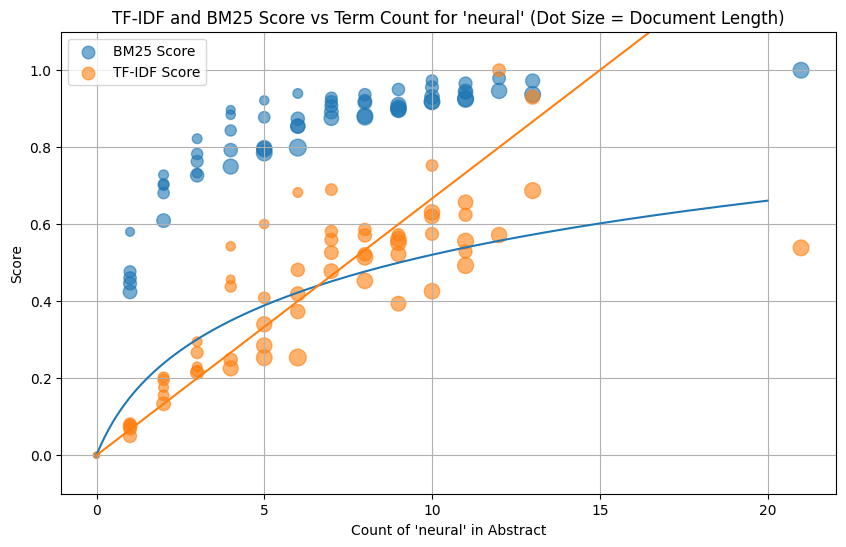

In [7]:
plt.figure(figsize=(10, 6))

sizes = [l / 2 for l in lengths]

# Compare BM25 and Log Curve
plt.scatter(bm25_counts, bm25_norm, s=sizes, alpha=0.6, label="BM25 Score")
x = np.linspace(0, 20, 500)
y1 = np.log10(x + 1) / 2
plt.plot(x, y1)

y2 = x/15
plt.plot(x, y2)
plt.scatter(tfidf_counts, tfidf_norm, s=sizes, alpha=0.6, label="TF-IDF Score")

plt.xlabel(f"Count of '{word}' in Abstract")
plt.ylabel("Score")
plt.title(f"TF-IDF and BM25 Score vs Term Count for '{word}' (Dot Size = Document Length)")
plt.grid(True)
plt.legend()
plt.ylim(-0.1, 1.1)

plt.show()

### The plot shows that TF-IDF increases almost linearly with term frequency, while BM25 saturates and avoids over-rewarding repetition. This indicates that frequency alone does not imply relevance, and BM25 offers a more balanced and context-aware signal—making it better suited for RAG retrieval.

In [8]:
query_embedding = model.encode([query])
similarities = cosine_similarity(query_embedding, document_embeddings)[0]
worst_indices = np.argsort(similarities)[:3]
best_indices = np.argsort(similarities)[::-1][:3]
embeddings = np.concatenate([query_embedding, document_embeddings[best_indices], document_embeddings[worst_indices]], axis=0)

In [9]:
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=5, max_iter=300)
reduced_tsne = tsne.fit_transform(embeddings)

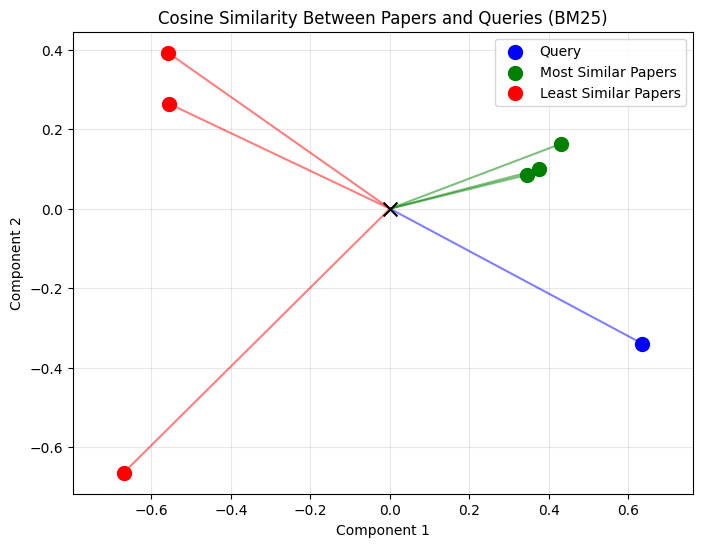

In [10]:
plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red']
labels = ['Query', 'Most Similar Papers', 'Least Similar Papers']
groups = [slice(0, 1), slice(1, 4), slice(4, None)]

for color, label, group in zip(colors, labels, groups):
  points = reduced_pca[group]

  for point in points:
    plt.plot([0, point[0]], [0, point[1]],
              color=color, alpha=0.5, linewidth=1.5)

  plt.scatter(points[:, 0], points[:, 1],
              color=color, label=label, s=100, zorder=5)

plt.scatter(0, 0, color='black', s=100, marker='x', zorder=10)

plt.title('Cosine Similarity Between Papers and Queries (BM25)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

### Relevant papers cluster near the query, while irrelevant ones diverge sharply—showing BM25 clearly distinguishes meaningful matches.

## Level 3_Reranking

In [11]:
 #  Neural Reranking with Cross-Encoders
 print("Using Corss Encode to reranking top 100 files")
 candidates = combined_ranking(query, 100, title_term_table, abstract_term_table, title_lengths, abstract_lengths, avg_doc_len_title, avg_doc_len_abs, N, model, document_embeddings)

 candidates_with_text = []
 # put in the text to rerank 
 for doc_id, score in candidates:
     abstract = df.iloc[doc_id].get("abstract", "")
     title    = df.iloc[doc_id].get("title", "")
     text     = title + " " + abstract            
     candidates_with_text.append((doc_id, text))

 reranked = retrieve_and_rerank(
     query,
     candidates_with_text,
     tokenizer_model = "bert-base-uncased",
     cross_encoder_model = "bert-base-uncased"
 )

Using Corss Encode to reranking top 100 files


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
# write the results from level2 and level 3 into dataframe
original_ranks = {doc_id: rank for rank, (doc_id, _) in enumerate(candidates, start=1)}

rows = []
for rank_after, (score_after, doc_id, text) in enumerate(reranked, start=1):
    row = df.iloc[doc_id]
    rows.append({
        "doc_id": doc_id,
        "score_after": score_after,
        "rank_after": rank_after,
        "rank_before": original_ranks.get(doc_id, None),
        "title": row.get("title", ""),
        "update_date": row.get("update_date", None),
        "arxiv_id": row.get("id", None),
    })

results_df = pd.DataFrame(rows)

if results_df["update_date"].dtype == "object":
    results_df["update_date"] = pd.to_datetime(results_df["update_date"], errors="coerce")

results_df.head()


,doc_id,score_after,rank_after,rank_before,title,update_date,arxiv_id
0,96449,0.235488,1,23,Rag and Roll: An End-to-End Evaluation of Indi...,2024-08-13,2408.05025
1,141797,0.234260,2,72,RAG Security and Privacy: Formalizing the Thre...,2025-09-25,2509.20324
2,92845,0.141611,3,45,Pistis-RAG: Enhancing Retrieval-Augmented Gene...,2024-11-04,2407.00072
3,96435,0.123716,4,40,ConfusedPilot: Confused Deputy Risks in RAG-ba...,2024-10-24,2408.04870
4,119988,0.121617,5,89,Contradiction Detection in RAG Systems: Evalua...,2025-04-02,2504.00180


### The cross-encoder reranker noticeably reshapes the ranking results by promoting papers that were originally much lower in the candidate list but more semantically relevant to the query. This shows that neural reranking provides finer-grained relevance judgment than BM25 and dense embeddings alone.

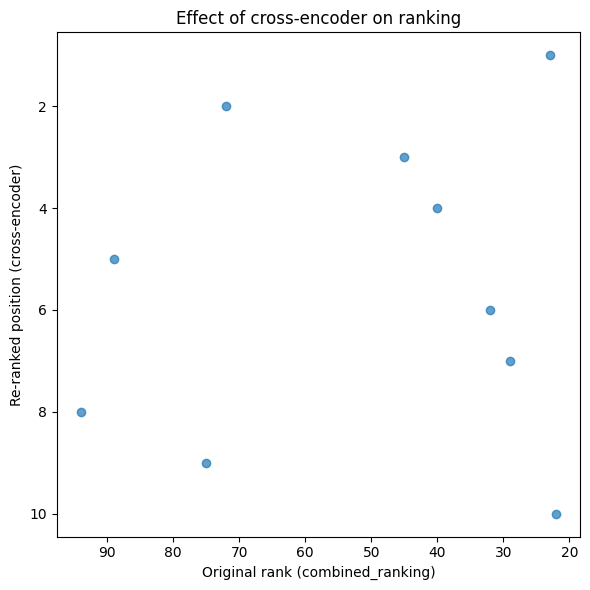

In [13]:
# ranking vs reranked

valid_df = results_df.dropna(subset=["rank_before"])

plt.figure(figsize=(6, 6))
plt.scatter(valid_df["rank_before"], valid_df["rank_after"], alpha=0.7)
plt.xlabel("Original rank (combined_ranking)")
plt.ylabel("Re-ranked position (cross-encoder)")
plt.title("Effect of cross-encoder on ranking")


plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


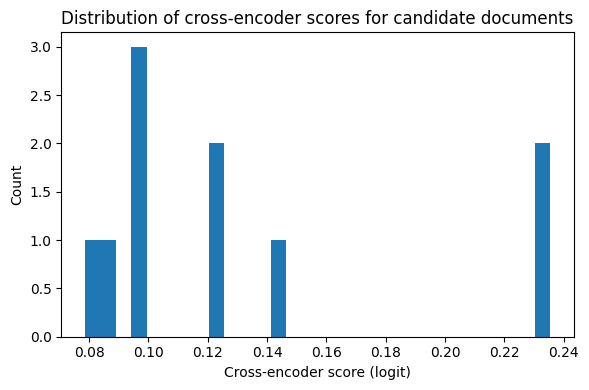

In [14]:
plt.figure(figsize=(6, 4))
plt.hist(results_df["score_after"], bins=30)
plt.xlabel("Cross-encoder score (logit)")
plt.ylabel("Count")
plt.title("Distribution of cross-encoder scores for candidate documents")
plt.tight_layout()
plt.show()
